In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import seaborn as sns

### Reading Data

In [2]:
train = pd.read_csv('./train_data_resamples.csv')
test = pd.read_csv('./test_data_resamples.csv')

In [3]:
print("Training Data Size: ", train.shape)
print("Testing Data Size: ", test.shape)

Training Data Size:  (98, 54)
Testing Data Size:  (47, 54)


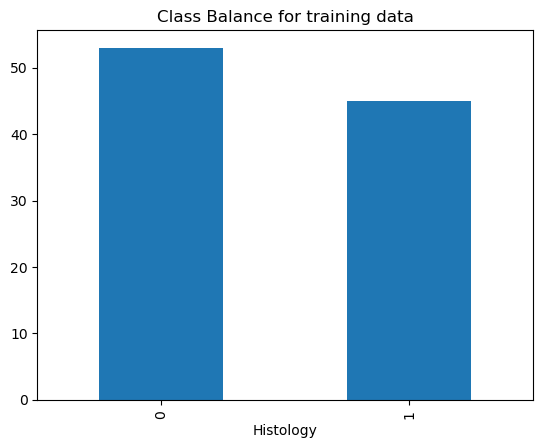

In [5]:
#checking class balance plot grouby label
train.groupby('Histology').size().plot(kind='bar')
plt.title('Class Balance for training data')
plt.show()


### Feature Selction

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Columns that should not be scaled
columns_to_exclude = ['Case ID', 'Histology']

# Columns that should be scaled
columns_to_scale = train.columns.difference(columns_to_exclude)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your data and transform the data
df_scaled = scaler.fit_transform(train[columns_to_scale])

# Create a new DataFrame with the scaled values in the relevant columns
df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale, index=train.index)

# Concatenate the non-scaled and scaled columns to form the full DataFrame
data = pd.concat([train[columns_to_exclude], df_scaled], axis=1)

# Initialize a classifier
clf = RandomForestClassifier(n_estimators=100)

X = train.drop(['Case ID', 'Histology'], axis=1)
Y = train['Histology']
# Use RFECV for feature selection
selector = RFECV(estimator=clf, step=1, cv=5)
selector = selector.fit(X, Y)

# Select the important features based on RFE
X_train_selected = selector.transform(X)


print(f"Number of features selected: {selector.n_features_}")
print(f"Selected features: {X.columns[selector.support_]}")
selected_columns = X.columns[selector.support_]

Number of features selected: 15
Selected features: Index(['Age at Histological Diagnosis', 'Weight (lbs)', '%GG',
       'EGFR mutation status', 'KRAS mutation status',
       'ALK translocation status', 'LRIG1', 'HPGD', 'VCAM1', 'CD44', 'CD4',
       'SPI1', 'VIM', 'LMO2', 'EGR2'],
      dtype='object')


In [16]:
X_train = train[selected_columns]
X_test = test[selected_columns]
y_train = train['Histology'] 
y_test = test['Histology']

### Grid Search

In [34]:
# train the model on train set 
model = SVC() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        26
           1       0.76      0.62      0.68        21

    accuracy                           0.74        47
   macro avg       0.75      0.73      0.73        47
weighted avg       0.75      0.74      0.74        47



In [36]:
# defining parameter range 
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}  
  
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 
# print best parameter after tuning 
print(grid.best_params_) 
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 2/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 3/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.526 total time=   0.0s
[CV 5/5] END .......C=0.01, gamma=1, kernel=rbf;, score=0.526 total time=   0.0s
[CV 1/5] END ......C=0.01, gamma=1, kernel=poly;, score=0.800 total time=   0.0s
[CV 2/5] END ......C=0.01, gamma=1, kernel=poly;, score=0.850 total time=   0.0s
[CV 3/5] END ......C=0.01, gamma=1, kernel=poly;, score=0.850 total time=   0.0s
[CV 4/5] END ......C=0.01, gamma=1, kernel=poly;, score=0.895 total time=   0.0s
[CV 5/5] END ......C=0.01, gamma=1, kernel=poly;, score=0.895 total time=   0.0s
[CV 1/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 2/5] END ...C=0.01, gamma=1, kernel=sigmoi

              precision    recall  f1-score   support

           0       0.80      0.77      0.78        26
           1       0.73      0.76      0.74        21

    accuracy                           0.77        47
   macro avg       0.76      0.77      0.76        47
weighted avg       0.77      0.77      0.77        47



<Axes: >

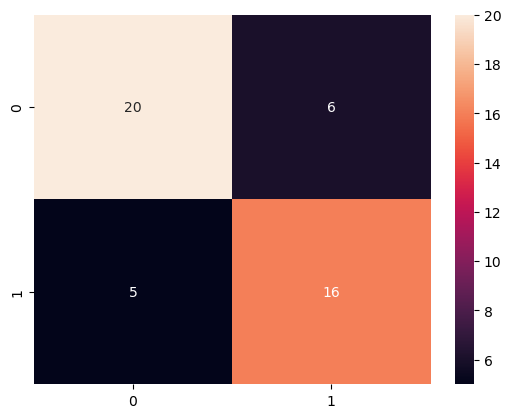

In [38]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
#print confusion matrix using seaborn
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True, fmt='d')